### Importy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
%matplotlib inline
import seaborn as sns
import datetime
from os import listdir

### Lista parametrow.

In [2]:
parameters = {'TC_FAN_STATE': 1006,
              'TC_COMPRESSOR_STATE': 1007,
              'TC_EVI_STATE': 1008,
              'TC_REVERSING_VALVE_STATE': 1009,
              'TC_DRIP_TRAY_DEFROST_STATE': 1010,
              'TC_DHW_HEATER_STATE': 1011,
              'TC_UPPER_SOURCE_PUMP_STATE': 1014,
              'TC_HEATING_VALVE_STATE': 1015,
              'TC_COMPRESSOR_BACKUP_HEATER_STATE': 1016,
              'TC_DHW_TEMP': 1020,
              'TC_OUTSIDE_TEMP': 1021,
              'TC_COMPRESSED_GAS_TEMP': 1022,
              'TC_BUFFER_TEMP_UPPER': 1023,
              'TC_BUFFER_TEMP_LOWER': 1024,
              'TC_CONDENSER_TEMP': 1025,
              'TC_EVAPORATOR_TEMP': 1026,
              'TC_UPPER_SOURCE_RETURN_TEMP': 1027,
              'TC_UPPER_SOURCE_IN_TEMP': 1028,
              'TC_COMPRESSOR_OIL_TEMP': 1029,
              'TC_CURRENT_FLOW': 1107,
              'TC_CURRENT_BUFFER_SETPOINT': 1624,
              'TC_UPPER_SOURCE_DELTA': 1648,
              'TC_EVD_PROBE_S1_READING': 1657,
              'TC_EVD_PROBE_S2_READING': 1658,
              'TC_EVD_PROBE_S3_READING': 1659,
              'TC_EVD_PROBE_S4_READING': 1660,
              'TC_EVD_SUCTION_TEMPERATURE': 1661,
              'TC_EVD_EVAPORATION_TEMPERATURE': 1662,
              'TC_EVD_EVAPORATION_PRESSURE': 1663,
              'TC_EVD_SUPER_HEAT': 1666,
              'TC_EVD_CONDENSING_PRESSURE': 1668,
              'TC_EVD_CONDENSING_TEMPERATURE': 1669,
              'TC_EVD_VALVE_OPENING': 1674,
              'TC_CURRENT_POWER_CONSUMPTION': 1701,
              'TC_CURRENT_ENERGY_OUTPUT': 1715,
              'TC_CURRENT_COP': 1734,
              'TC_HEATER_CURRENT_MINUTE_DEGREE': 1813,
              'TC_MINUTES_SINCE_LAST_DEFROST': 1814,
              'TC_COMPRESSOR_LAST_WORK_TIME': 1816,
              'TC_COMPRESSOR_LAST_STOP_TIME': 1818
             }

### Lista modułów.

In [3]:
modules = [20752, 21834, 23082,  5599, 10865, 16031]

### Funkcje pomocnicze.

In [4]:
def get_value(val):
    arr_val = val.split(',')
    type = int(arr_val[2])
    if type == 1:
        return int(arr_val[6])
    elif type == 6:
        return int(arr_val[11])
    elif type == 11:
        return int(arr_val[4])
    else:
        print('Error: Id: {} Type {} unsupport!'.format(arr_val[0], type))
        return np.nan

In [5]:
def prepare_data_for_module(id_module, data, parameters):
    data = data[data.id_module == id_module]
    data = data.drop_duplicates(['id_status', 'time'], keep='last')    
    columns = list(parameters.keys())
    columns.append('TIME')
    module_data = pd.DataFrame(columns=columns)
    time = data.time.unique()
    module_data['TIME'] = time
    for k in parameters:
        module_time = data[data.id_status == parameters[k]]['time'].values
        if module_time.shape[0] > 0:
            dif_time = np.setdiff1d(time, module_time)
            calc_index = []
            for dif in dif_time:
                calc_index.append(np.where(time == dif)[0][0])
            d = data[data.id_status == parameters[k]]['val'].values
            for i in calc_index:
                d = d.astype(float)
                d = np.insert(d, i, np.nan)
            module_data[k] = d
        else:
            print("Error: Not fount parameter: {}".format(k))
    return module_data

In [6]:
def get_list_of_days(start, end):
    start = datetime.datetime.strptime(start, "%Y-%m-%d")
    end = datetime.datetime.strptime(end, "%Y-%m-%d")
    return (start + datetime.timedelta(days=x) for x in range(0, (end-start).days))

In [7]:
def get_days_and_modules_with_alarm():
    alarm_files = [f for f in listdir("../data") if f[10:] == '_alarms.csv']
    alarms_modules = {}
    for alarm_file in alarm_files:
        df = pd.read_csv('../data/{}'.format(alarm_file))
        modules = df.id_module.unique()
        alarms_modules[alarm_file[:10]] = modules
    return alarms_modules

### Dane

In [77]:
date_start = '2019-12-06'
date_end = '2020-01-17'
days = get_list_of_days(date_start, date_end)
days = list(map(lambda d: d.strftime("%Y-%m-%d"), days))

In [78]:
def create_data(days, modules, parameters):
    all_data = pd.DataFrame()
    all_data_init = False
    alarms_modules = get_days_and_modules_with_alarm()
    for day in days:
        path = '../data/{}.csv'.format(day)
        try:
            df = pd.read_csv(path)
            df.time = pd.to_datetime(df.time)
            for module in modules:
                if module in alarms_modules.get(day, []):
                    print("Moduł {} dnia {} postadał alarm".format(module, day))
                else:
                    data = df.copy()
                    data = data[data.id_status.isin(parameters.values())]
                    data = data.sort_values('time')
                    data['val'] = data['value'].apply(get_value)
                    data = data.drop('value', axis=1)
                    data.time = data.time.apply(lambda x: x.time().replace(second=0, microsecond=0))
                    data_module = prepare_data_for_module(module, data, parameters)
                    data_module['WORK_TIMER'] = data_module.TC_COMPRESSOR_STATE * data_module.TC_COMPRESSOR_LAST_WORK_TIME
                    if not all_data_init:
                        all_data = data_module.copy()
                        all_data_init = True
                    else:
                        all_data = all_data.append(data_module)
        except Exception as e:
            print(e)
    print("Data shape: {}".format(all_data.shape))
    return all_data

In [79]:
%time data = create_data(days, modules, parameters)

[Errno 2] File b'../data/2019-12-06.csv' does not exist: b'../data/2019-12-06.csv'
Moduł 23082 dnia 2019-12-07 postadał alarm
Moduł 5599 dnia 2019-12-07 postadał alarm
Error: Not fount parameter: TC_EVD_PROBE_S4_READING
Error: Not fount parameter: TC_EVD_PROBE_S4_READING
Moduł 20752 dnia 2019-12-08 postadał alarm
Moduł 23082 dnia 2019-12-08 postadał alarm
Error: Not fount parameter: TC_EVD_PROBE_S4_READING
Error: Not fount parameter: TC_EVD_PROBE_S4_READING
Moduł 20752 dnia 2019-12-09 postadał alarm
Moduł 23082 dnia 2019-12-09 postadał alarm
Error: Not fount parameter: TC_EVD_PROBE_S4_READING
Error: Not fount parameter: TC_EVD_PROBE_S4_READING
Moduł 5599 dnia 2019-12-10 postadał alarm
Error: Not fount parameter: TC_EVD_PROBE_S4_READING
Error: Not fount parameter: TC_EVD_PROBE_S4_READING
Moduł 20752 dnia 2019-12-11 postadał alarm
Error: Not fount parameter: TC_EVD_PROBE_S4_READING
Error: Not fount parameter: TC_EVD_PROBE_S4_READING
[Errno 2] File b'../data/2019-12-12.csv' does not exist

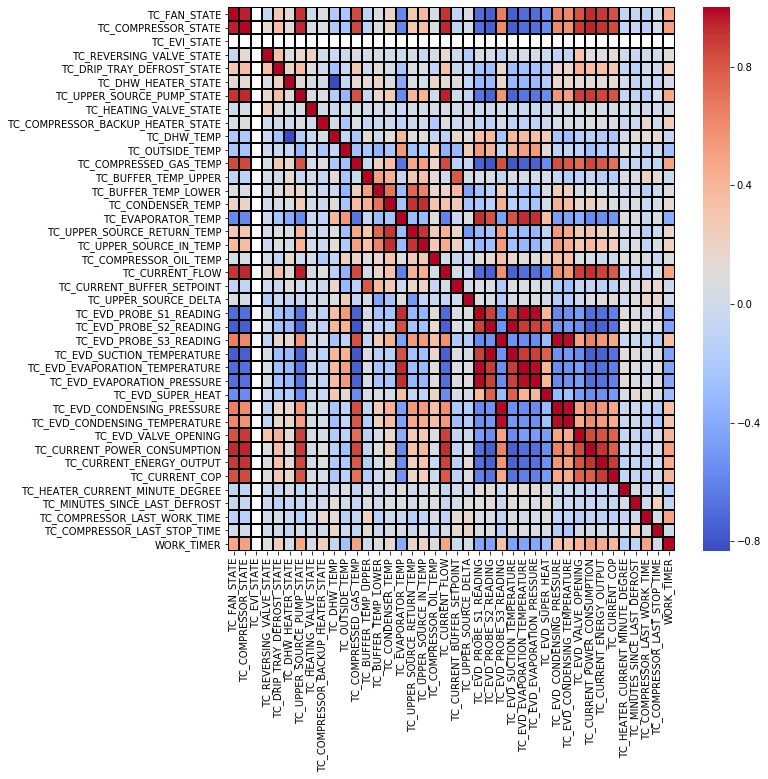

In [80]:
columns = list(parameters.keys())
columns.append('WORK_TIMER')
corr = data[columns].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap= 'coolwarm', linewidths=1, linecolor='black', annot=False)

In [2]:
data.to_csv('../data_for_models/data.csv')

NameError: name 'data' is not defined

In [3]:
data = pd.read_csv('../data_for_models/data.csv')

In [4]:
sns.pairplot(data=data);

/home/marcin/anaconda3/envs/databaseenv/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/marcin/anaconda3/envs/databaseenv/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


KeyboardInterrupt: 

MemoryError: In RendererAgg: Out of memory

<Figure size 7560x7560 with 1806 Axes>